# Ezequiel Garcia - Tobias Giacri

## Inicializacion / Set-up de environment

In [91]:
# pip install scikit-learn
# pip install numpy
# pip install matplotlib

In [92]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
import time

## Carga de datos

In [93]:
from sklearn.model_selection import train_test_split
import numpy as np

# Cargar los datos desde el archivo de texto
vda   = np.loadtxt("samplesVDA1.txt")

cant_datos = vda.shape[0]
medidas_x_segundo = 400 
npyarray=np.array
tiempo = np.arange(0,cant_datos/400,1/medidas_x_segundo)
tiempo = tiempo*1000

data_y = vda.reshape(-1,1) 
data_x = tiempo.reshape(-1,1)

# Divide los datos en conjuntos de entrenamiento y prueba de manera aleatoria
vda_entrenamiento, vda_prueba, tiempo_entrenamiento, tiempo_prueba = train_test_split(data_y, data_x, test_size=0.2, random_state=42)

data = np.hstack((tiempo_entrenamiento,vda_entrenamiento)) # datos de entrenamiento
dataTest = np.hstack((tiempo_prueba,vda_prueba)) # datos testing

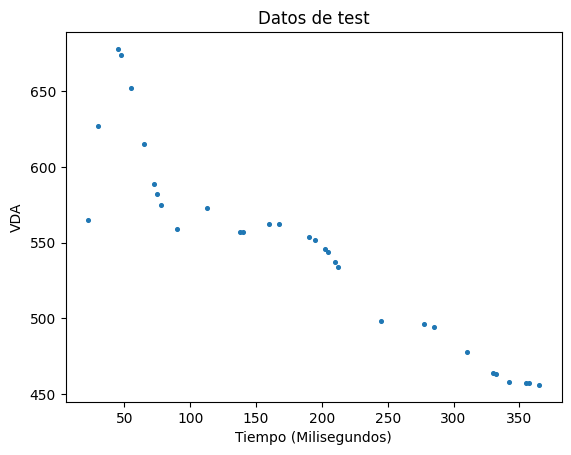

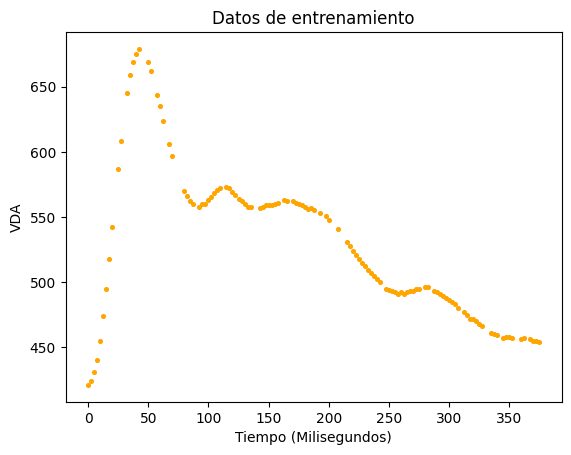

In [94]:
plt.figure()
plt.scatter(tiempo_prueba, vda_prueba, s = 7)
plt.xlabel('Tiempo (Milisegundos)')
plt.ylabel('VDA')
plt.title('Datos de test')
plt.legend
plt.show()

plt.scatter(tiempo_entrenamiento, vda_entrenamiento, s=7, c='orange')
plt.xlabel('Tiempo (Milisegundos)')
plt.ylabel('VDA')
plt.title('Datos de entrenamiento')
plt.show()


## CLUSTERING K-MEANS
Definicion de funcion

In [95]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def clusteringk(data,nclusters,mostrar=True):

    # Crear un objeto KMeans
    kmeans = KMeans(n_clusters=nclusters, n_init=19)

    # Ajustar el modelo a tus datos
    kmeans.fit(data)

    # Obtener los centroides de los clusters
    centroides = kmeans.cluster_centers_

    # Obtener las etiquetas de cluster para cada punto de datos
    etiquetas = kmeans.labels_

    if mostrar:

        # Visualizar los resultados
        plt.scatter(data[:, 0], data[:, 1], c=etiquetas)
        plt.scatter(centroides[:, 0], centroides[:, 1], marker='x', s=200, linewidths=3, color='r')
        plt.title(f'Clustering con K-Means (k={nclusters})')
        plt.show()
        
    return etiquetas,centroides


## Algoritmo de Sugeno
Modificado para funcionar con K-means

In [96]:
"""
Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.
"""


def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))

######################################################################

class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma

#################################################################################################################

# ESTA EDITADO EL DEF VIEW PARA AGRANDAR EL ESPACIO EN X EN EL GRAFICO

class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids


    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        #x = np.linspace(self.minValue -400,self.maxValue + 400,30)

        plt.figure()
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.plot(x,y)

##################################################################################################################

class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []


###################################################################################################################
    def genfis(self, data, clusters):

        start_time = time.time()
        #El método comienza midiendo el tiempo de ejecución.

        labels, cluster_center = clusteringk(data,clusters) # Se cambio el clustering substractivo a kmeans (numero de clusters como entrada)

        n_clusters = len(cluster_center)
        cluster_center = cluster_center[:,:-1]
         #  Se calcula el número de clusters obtenidos (n_clusters) a partir de los centroides y se recorta la última columna de cluster_center,
         #  que generalmente contiene información adicional que no se utiliza en el modelo Sugeno.


        P = data[:,:-1]
        # Se obtienen las variables de entrada P a partir de los datos de entrada data. Luego,
        #  se calculan los valores máximos (maxValue) y mínimos (minValue) de cada variable de entrada.

        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        #  Se crea una lista de objetos fisInput para cada variable de entrada. Cada objeto fisInput se inicializa con su valor máximo, mínimo y
        #  los centroides de los clusters correspondientes a esa variable.
        self.rules = cluster_center
        self.entrenar(data)
        print("--- Tiempo de ejecucion %s seconds ---" % (time.time() - start_time))

######################################################################################################################
    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
# P contiene las variables de entrada del conjunto de datos data.
# T contiene las salidas deseadas (target) del conjunto de datos data.
        
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs]) 
        #Aquí se calcula la desviación estándar sigma para las funciones de membresía gaussianas utilizadas en el sistema Sugeno.
        #  self.inputs contiene información sobre las variables de entrada.
        
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]
        #  Se calcula la activación de cada regla para cada instancia del conjunto de datos P.
        #  Esto se hace multiplicando las funciones de membresía gaussianas por cada regla y luego tomando el producto.
        #  El resultado es una lista de valores de activación para cada regla y cada instancia de entrada.

        nivel_acti = np.array(f).T
        #  nivel_acti es una matriz donde cada fila corresponde a una instancia del conjunto de datos y cada columna corresponde a una regla.
        #  Contiene los valores de activación de cada regla para cada instancia.


        #print("nivel acti")
        #print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        # sumMu es un vector que contiene la suma de los valores de activación para cada instancia. 
        # Esto se usa en el cálculo de los coeficientes del sistema Sugeno.
        #print("sumMu")
        #print(sumMu)

        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]

        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        # Aquí se preparan los datos para el cálculo de los coeficientes. Se añade una columna de unos a la matriz P, 
        # luego se calculan las matrices acti e inp que se utilizan para construir la matriz de coeficientes A.
        


        A = acti*inp/sumMu
        #A es la matriz de coeficientes que se utiliza en el sistema de ecuaciones lineales.

        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu

        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        #Se resuelve el sistema de ecuaciones lineales utilizando mínimos cuadrados y se almacenan las soluciones en self.solutions.
        #print(solutions)
        return 0


###############################################################################################################
    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti*inp*coef/sumMu,axis=1)

#  En resumen, este tramo toma un conjunto de datos de entrada y utiliza el sistema Sugeno previamente entrenado para calcular las salidas correspondientes.
#  este método asume que las variables de entrada y las reglas ya están configuradas en la instancia de la clase fis y
#  que los coeficientes del sistema Sugeno se han calculado previamente durante el entrenamiento


#################################################################################################################

    def viewInputs(self):
        for input in self.inputs:
            input.view()






## Entrenamiento


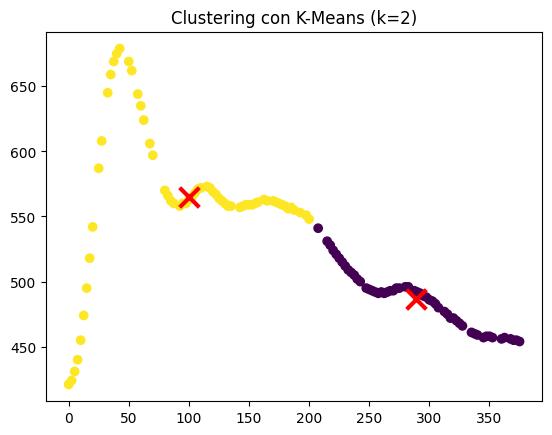

--- Tiempo de ejecucion 0.19699907302856445 seconds ---
[62.40175832 54.39062229 70.56265776 69.31910953 41.66893479 28.21494173
 65.30437427 41.75519936 23.59110692 73.99548206  2.05286568 65.45248763
 17.54336478 70.70585091 52.47833737 53.06379781 81.10331077 35.44705998
 25.686177   59.81555406 32.40719364 72.90176752 38.59507534 61.3907789
 72.25334566 43.66780965 82.65801577 47.3728624  83.25166724 30.31730095
 46.63119388] de [554.] - 491.5982416799293
[186.40175832  69.60937771 194.56265776 193.31910953 165.66893479
  95.78505827 189.30437427 165.75519936 147.59110692 197.99548206
 126.05286568  58.54751237 106.45663522  53.29414909  71.52166263
 177.06379781 205.10331077 159.44705998 149.686177   183.81555406
  91.59280636 196.90176752  85.40492466 185.3907789  196.25334566
 167.66780965 206.65801577 171.3728624  207.25166724  93.68269905
  77.36880612] de [678.] - 608.3906222863754
[52.40175832 64.39062229 60.56265776 59.31910953 31.66893479 38.21494173
 55.30437427 31.755199

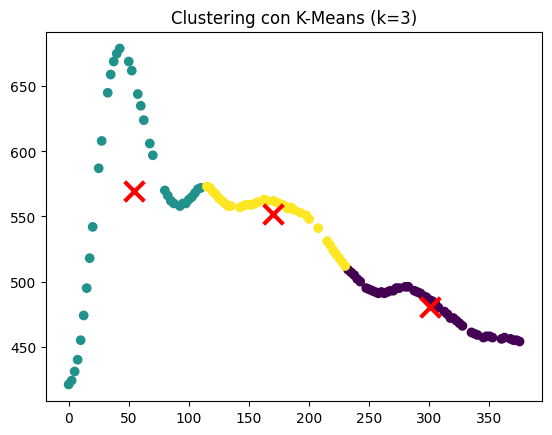

--- Tiempo de ejecucion 0.23186659812927246 seconds ---
[ 24.26496202  60.0403796   25.41893403  25.26937097 100.34128065
  66.39368683  24.74965862  15.63400537   0.67302546  25.90718818
  28.30486801  27.10181022  55.07683682   0.53517755  63.27473461
 105.51064023  61.32058118  92.50282768   1.59884922 102.89298281
  69.43225882  25.73004322  71.78973657 101.65615995  86.13674332
 102.10853061  54.3620535   19.01504546  32.85472579  68.04285293
  69.71776596] de [554.] - 529.7350379824275
[148.26496202  63.9596204  149.41893403 149.26937097 224.34128065
  57.60631317 148.74965862 139.63400537 123.32697454 149.90718818
  95.69513199  96.89818978  68.92316318 123.46482245  60.72526539
 229.51064023 185.32058118 216.50282768 125.59884922 226.89298281
  54.56774118 149.73004322  52.21026343 225.65615995 210.13674332
 226.10853061 178.3620535  143.01504546 156.85472579  55.95714707
  54.28223404] de [678.] - 614.0403796000755
[14.26496202 70.0403796  15.41893403 15.26937097 90.34128065 7

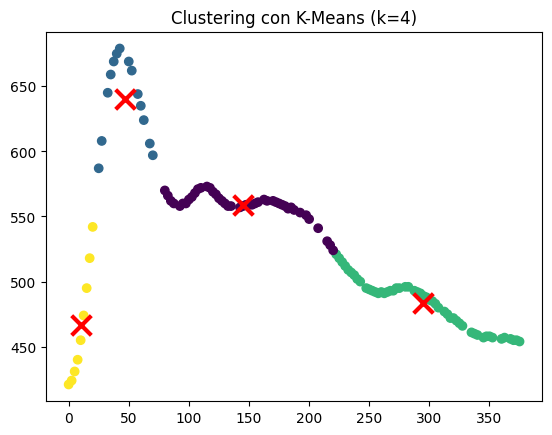

--- Tiempo de ejecucion 0.19005608558654785 seconds ---
[ 5.19133555 11.29965147 17.70783325 15.58223503 87.11863493 30.07333288
  9.289879   16.59698135 28.17700813 24.13236348 34.53940733  1.97275836
 33.53865265  9.64564105 13.2355267  89.48461011 77.40931303 85.12352833
 27.14320443 89.81186131 28.09892861 21.98552473 24.50885924 89.7338127
 86.78455358 87.66544648 73.44713676 11.71749013 51.27539938 29.12812433
 18.55862202] de [554.] - 548.808664453561
[129.19133555 112.70034853 141.70783325 139.58223503 211.11863493
  93.92666712 133.289879   107.40301865  95.82299187 148.13236348
  89.46059267 125.97275836  90.46134735 133.64564105 110.7644733
 213.48461011 201.40931303 209.12352833  96.85679557 213.81186131
  95.90107139 145.98552473  99.49114076 213.7338127  210.78455358
 211.66544648 197.44713676 112.28250987 175.27539938  94.87187567
 105.44137798] de [678.] - 565.2996514720542
[ 4.80866445 21.29965147  7.70783325  5.58223503 77.11863493 40.07333288
  0.710121   26.59698135

[9.855678302137278, 10.345426859992768, 9.135220228915518]

In [103]:
# GRAFICAR EL ERROR vs R
import numpy as np
import matplotlib.pyplot as plt

# Listas para almacenar los valores de error y clusters
mse = []
desde =  2 
hasta = 5
rango_clusters = range(desde, hasta)

for cant_clusters in rango_clusters:
    fis2 = fis()
    fis2.genfis(data, cant_clusters)

    x = fis2.evalfis(tiempo_prueba)  # testeo con los vda para testeo
    error = np.abs(x - vda_prueba)
    
        
    # Calcular el promedio de los errores
    promedio_error = np.mean(error)
    error_promedio_porcentual = promedio_error/np.max(data_y) 

    mse.append(error_promedio_porcentual*100)
mse

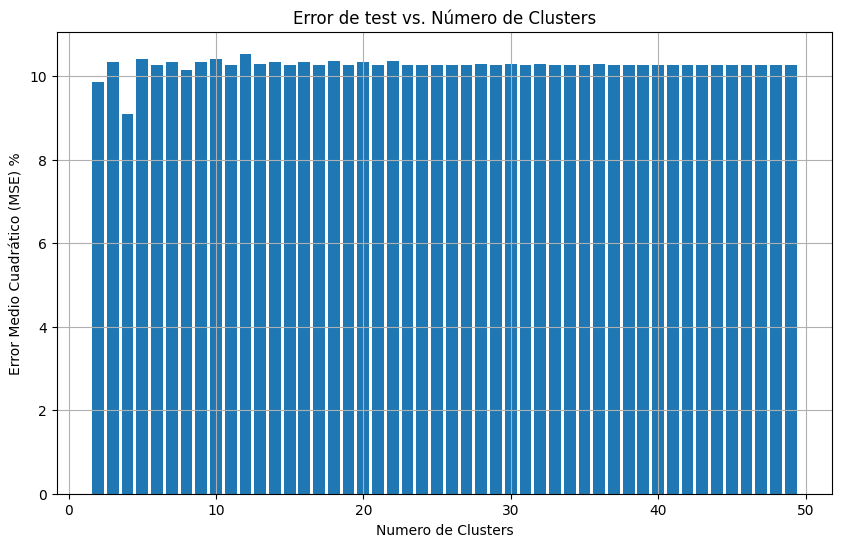

In [98]:
# Ahora, graficar el error vs. el número de clusters
plt.figure(figsize=(10, 6))
plt.bar(rango_clusters, mse)
plt.title('Error de test vs. Número de Clusters')
plt.xlabel('Numero de Clusters')
plt.ylabel('Error Medio Cuadrático (MSE) %')
plt.grid(True)
plt.show()

(302,)


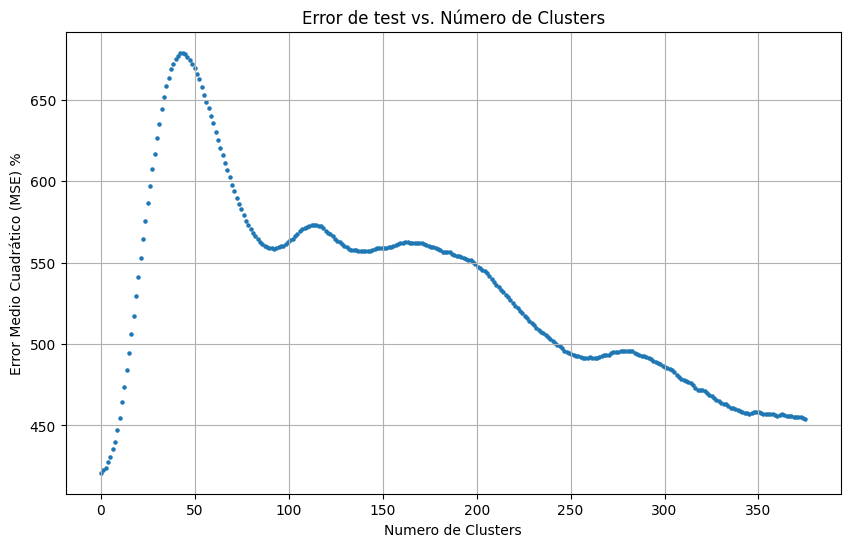

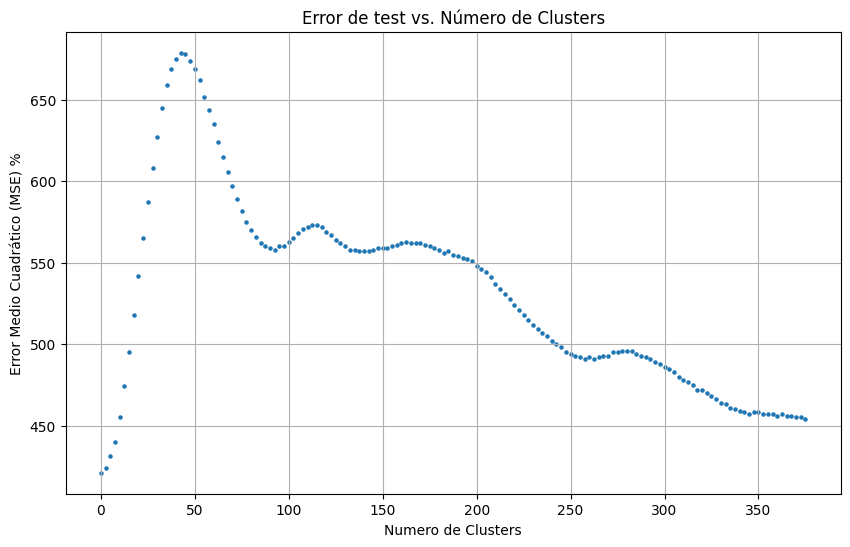

In [99]:
from scipy.interpolate import interp1d

f = interp1d(tiempo, vda, kind='linear')
x_new = np.linspace(0, np.max(tiempo), num=tiempo.shape[0]*2)
y_new = f(x_new)
print(y_new.shape)
#####################################################

plt.figure(figsize=(10, 6))
plt.scatter(x_new, y_new, s = 5)
plt.title('Error de test vs. Número de Clusters')
plt.xlabel('Numero de Clusters')
plt.ylabel('Error Medio Cuadrático (MSE) %')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(tiempo, vda, s = 5)
plt.title('Error de test vs. Número de Clusters')
plt.xlabel('Numero de Clusters')
plt.ylabel('Error Medio Cuadrático (MSE) %')
plt.grid(True)
plt.show()